# **Retail Sales Analysis modules**

## Objectives

* Create a set of modules to support the analysis of the Retail Sales Data set from Kaggle to act as demonstration of skills

## Inputs

* Data will be pulled using the Kaggle API.

## Outputs

* Multiple python modules that can be loaded and resused to support re-use of analytics

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

Hard code working directory to relative root directory of workbook.

In [2]:
import os
os.chdir('/workspace/RetailSalesRework')
print("You set a new current directory")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/workspace/RetailSalesRework'

In [1]:
## Modules and Extensions imported
import pandas as pd
import os
import math
import numpy as np
from datetime import timedelta, date
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.imputation import DropMissingData

# Data Acquisition

Load data using Kagglehub api - the user will need a Kaggle account and a kaggle api code.  Both of the can be obtained from [Kaggle.com](https://Kaggle.com/).  This project will be using the [Retail Data Anlaytics DataSet](https://www.kaggle.com/datasets/manjeetsingh/retaildataset)

In [3]:
## Setup Kagglehub and login
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
## load Retail Data Set using Kagglehub
kagglehub.dataset_download("manjeetsingh/retaildataset")

100%|██████████| 3.11M/3.11M [00:00<00:00, 7.79MB/s]

Extracting files...


'C:\\Users\\pgold\\.cache\\kagglehub\\datasets\\manjeetsingh\\retaildataset\\versions\\2'

In [6]:
## List of files in folder
os.listdir('C:\\Users\\pgold\\.cache\\kagglehub\\datasets\\manjeetsingh\\retaildataset\\versions\\2')

['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv']

In [9]:
## Load data sets
Features_df = pd.read_csv('C:\\Users\\pgold\\.cache\\kagglehub\\datasets\\manjeetsingh\\retaildataset\\versions\\2\Features data set.csv')
Stores_df = pd.read_csv('C:\\Users\\pgold\\.cache\\kagglehub\\datasets\\manjeetsingh\\retaildataset\\versions\\2\stores data-set.csv')
Sales_df = pd.read_csv('C:\\Users\\pgold\\.cache\\kagglehub\\datasets\\manjeetsingh\\retaildataset\\versions\\2\sales data-set.csv')
## Merge sales_df and Stores_df on Store id - change data type of Date to Date, Store to Object and Dept to Object,
Sales_df = pd.merge(Sales_df, Stores_df, how='left', on='Store')
Sales_df['Date'] = pd.to_datetime(Sales_df['Date'], format='%d/%m/%Y')
Sales_df['Store'] = Sales_df['Store'].astype(object)
Sales_df['Dept'] = Sales_df['Dept'].astype(object)
## Clean up Features_df then create store level summary
Features_df['Date'] = pd.to_datetime(Features_df['Date'], format='%d/%m/%Y')
# Change date to date format and create year/month and week fields and YearMonth YearWeek
# Append Year column
Sales_df['SalesYear'] = round(Sales_df['Date'].dt.year)
# Append Month column 
Sales_df['SalesMonth'] = round(Sales_df['Date'].dt.month)
# append quarters column
Sales_df['SalesQuarter'] = round(Sales_df['Date'].dt.quarter)
# Append Week column
Sales_df['SalesWeek'] = round(Sales_df['Date'].dt.isocalendar().week)
# Create YearMonth Column
Sales_df['SalesYearMonth'] = round(Sales_df['SalesYear']*100 +Sales_df['SalesMonth'])
# Create YearWeek Column
Sales_df['SalesYearWeek'] = round(Sales_df['SalesYear']*100 +Sales_df['SalesWeek'])
# Create Season Column
SeasonsDic = {1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring', 5:'Spring', 6:'Summer',7:'Summer', 8:'Summer', 9:'Autumn', 10:'Autumn', 11:'Autumn', 12:'Winter'}
Sales_df['SalesSeason'] = Sales_df['SalesMonth'].map(SeasonsDic)
SpecialSalesDic = {12:'Xmas', 3:'Easter', 4:'Easter',7:'Schoolholidays',8:'Schoolholidays',10:'Halloween'}
Sales_df['SpecialDate'] = Sales_df['SalesMonth'].map(SpecialSalesDic).fillna(Sales_df['SalesSeason'])
# Replace NaN in MarkDown as 0
Features_df['MarkDown1'] = Features_df['MarkDown1'].fillna(0)
Features_df['MarkDown2'] = Features_df['MarkDown2'].fillna(0)
Features_df['MarkDown3'] = Features_df['MarkDown3'].fillna(0)
Features_df['MarkDown4'] = Features_df['MarkDown4'].fillna(0)
Features_df['MarkDown5'] = Features_df['MarkDown5'].fillna(0)
Features_df['MarkDownTotal']= Features_df['MarkDown1']+Features_df['MarkDown2']+Features_df['MarkDown3']+Features_df['MarkDown4']+Features_df['MarkDown5']
Features_df['MarkDownData']= Features_df['MarkDownTotal']>0
# Use fillna forward on Unemployment and CPI
Features_df['CPI']=Features_df['CPI'].fillna(method='ffill')
Features_df['Unemployment']=Features_df['Unemployment'].fillna(method='ffill')

C:\Users\pgold\AppData\Local\Temp\ipykernel_17084\2196825645.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Features_df['CPI']=Features_df['CPI'].fillna(method='ffill')
C:\Users\pgold\AppData\Local\Temp\ipykernel_17084\2196825645.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Features_df['Unemployment']=Features_df['Unemployment'].fillna(method='ffill')


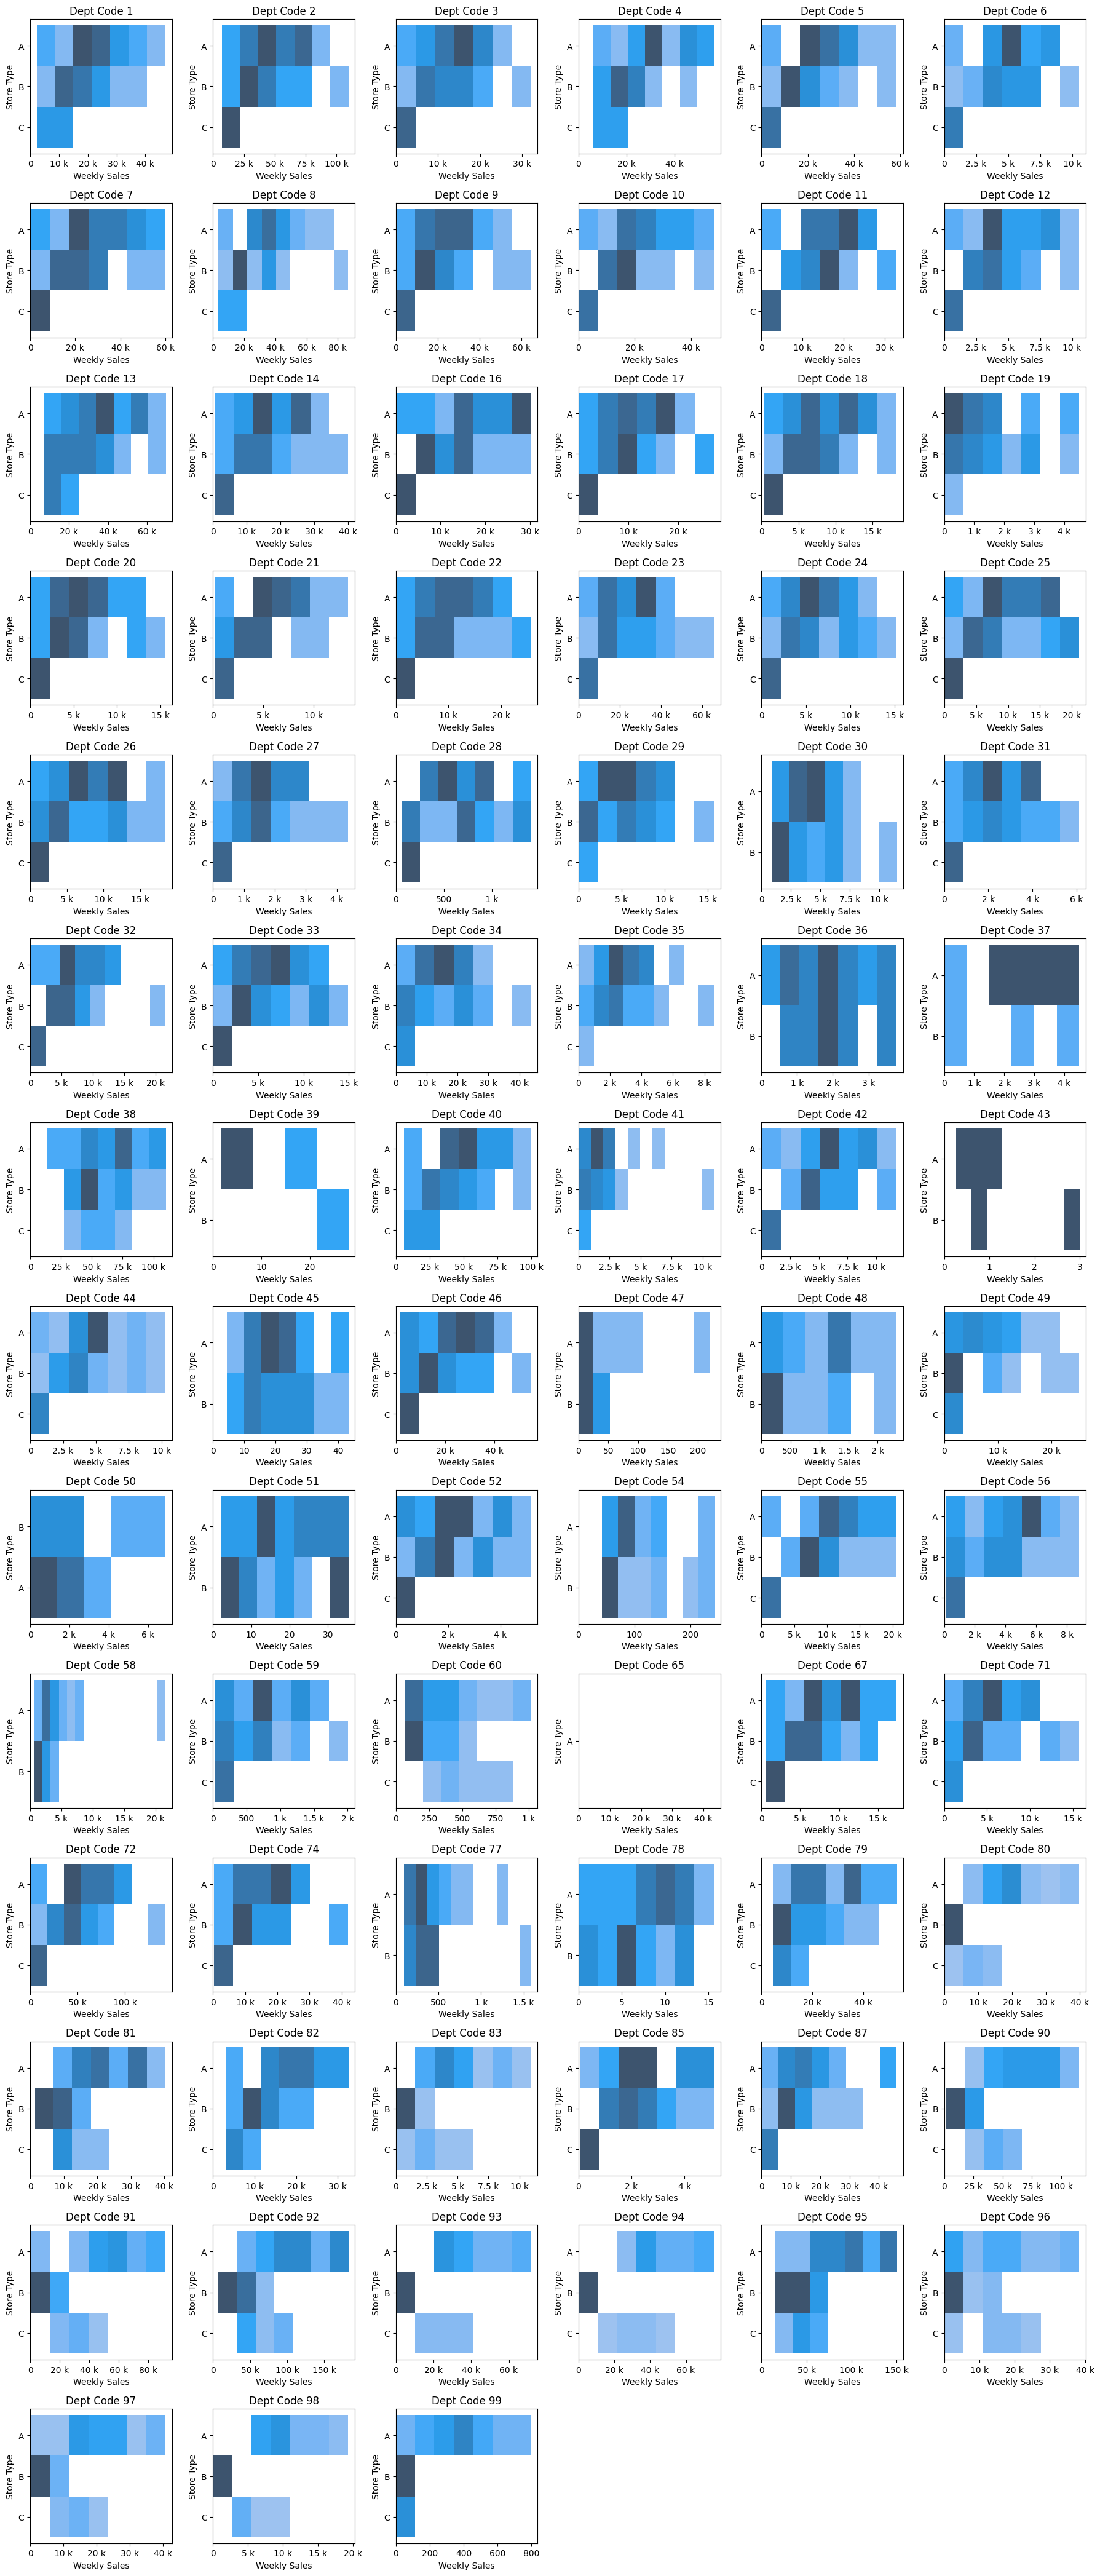

In [11]:
# Get unique values in Dept
unique_groups = Sales_df['Dept'].drop_duplicates().sort_values()

# Number of plots per row
plots_per_row = 6

# Calculate the required number of rows
num_rows = math.ceil(len(unique_groups) / plots_per_row)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(18, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each unique value in Dept and corresponding axes
for idx, group in enumerate(unique_groups):
    # Filter data for the current group
    group_data = Sales_df[Sales_df['Dept'] == group].groupby(['Store', 'Type'])['Weekly_Sales'].mean().reset_index()

    # Create a scatterplot for the current group
    sns.histplot(
        data=group_data,
        x='Weekly_Sales',
        y='Type',
        ax=axes[idx]  # Pass the specific subplot axis
        
    )

    # Add labels and title
    axes[idx].set_title(f'Dept Code {group}')
    axes[idx].set_xlabel('Weekly Sales')
    axes[idx].set_ylabel('Store Type')
    axes[idx].set_xlim(0,)
    axes[idx].xaxis.set_major_formatter(EngFormatter())  # Format x-axis for better readability

# Hide any unused axes
for ax in axes[len(unique_groups):]:
    ax.set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


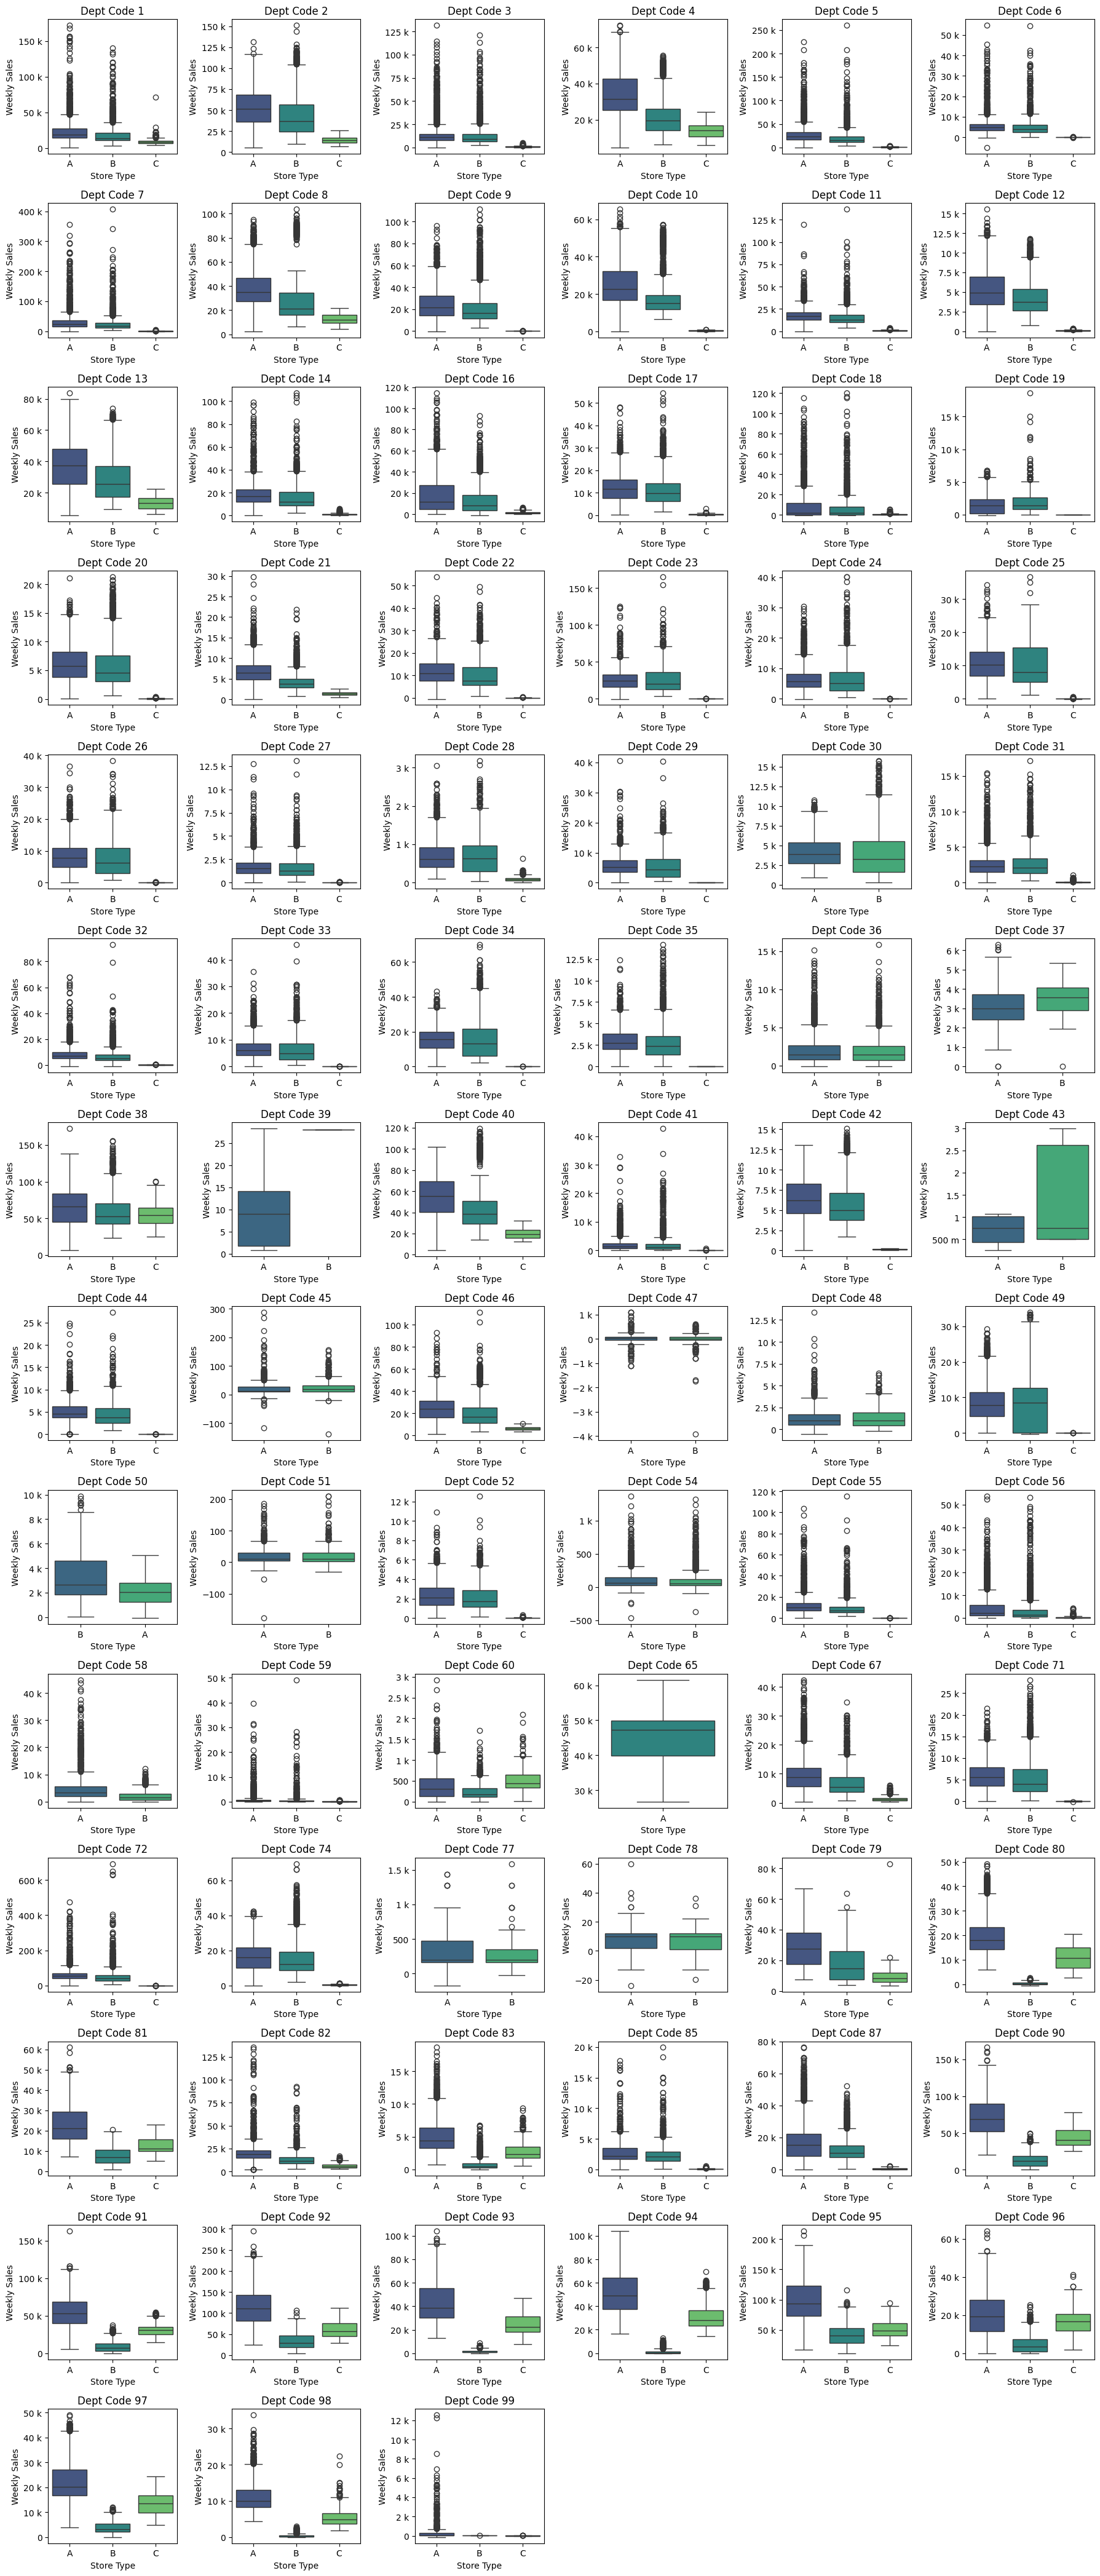

In [13]:
# Get unique values in Dept
unique_groups = Sales_df['Dept'].drop_duplicates().sort_values()
# Number of plots per row
plots_per_row = 6

# Calculate the required number of rows
num_rows = math.ceil(len(unique_groups) / plots_per_row)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(18, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each unique value in Dept and corresponding axes
for idx, group in enumerate(unique_groups):
    # Filter data for the current group
    group_data = Sales_df.loc[Sales_df['Dept'] == group, ['Weekly_Sales', 'Type']].dropna()
    
    # Create a boxplot for the current group
    sns.boxplot(
        data=group_data,
        x='Type',
        y='Weekly_Sales',
        ax=axes[idx],
        hue='Type',
        palette='viridis'
    )
    
    # Add labels and title
    axes[idx].set_title(f'Dept Code {group}')
    axes[idx].set_ylabel('Weekly Sales')
    axes[idx].set_xlabel('Store Type')
    axes[idx].yaxis.set_major_formatter(ticker.EngFormatter())
    

# Hide any unused axes
for ax in axes[len(unique_groups):]:
    ax.set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


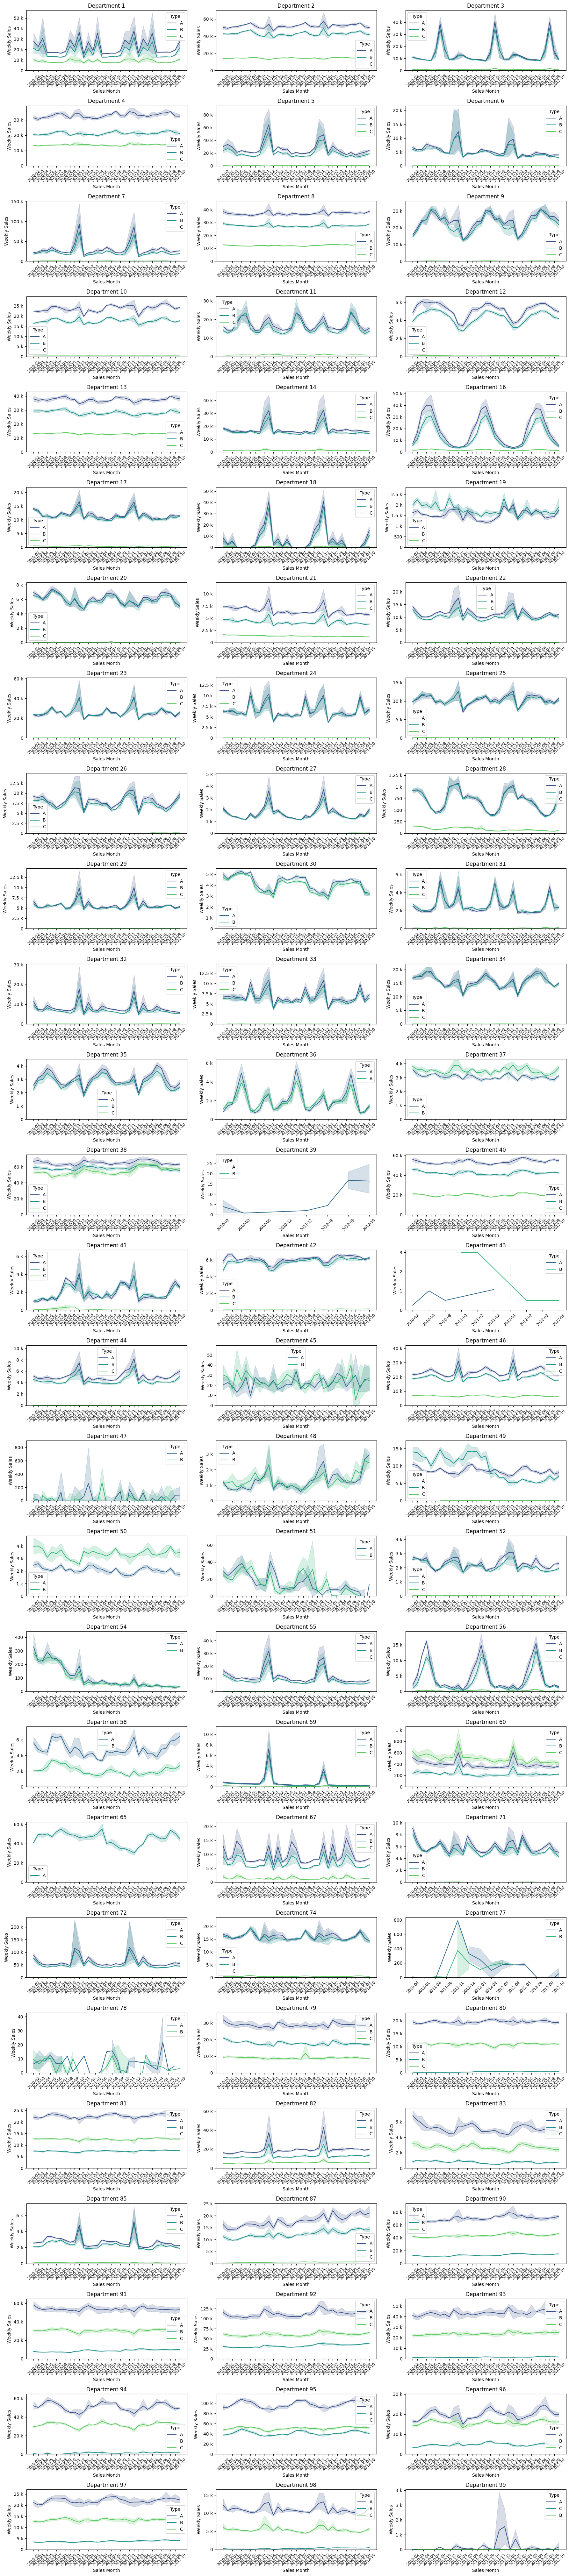

In [14]:
# Summarize data by month, department, and type
Sales_df_plot = (
    Sales_df.groupby(['Date', 'Dept', 'Type'])['Weekly_Sales']
    .mean()
    .reset_index()
    .sort_values(by=['Dept', 'Date'])
)

# Get unique department values
unique_groups = Sales_df_plot['Dept'].drop_duplicates().sort_values()

# Number of plots per row
plots_per_row = 3

# Calculate the required number of rows
num_rows = math.ceil(len(unique_groups) / plots_per_row)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(18, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each department and create a subplot
for idx, group in enumerate(unique_groups):
    # Filter data for the current department
    group_data = Sales_df_plot[Sales_df_plot['Dept'] == group].copy()
    group_data['SalesYearMonth'] = group_data['Date'].dt.to_period('M').astype(str)  # Convert to "YYYY-MM" format
    
    # Lineplot for the current department
    sns.lineplot(
        data=group_data,
        x='SalesYearMonth',
        y='Weekly_Sales',
        hue='Type',
        ax=axes[idx],
        palette='viridis'
    )
    
    # Format labels and titles
    axes[idx].set_title(f'Department {group}')
    axes[idx].set_ylabel('Weekly Sales')
    axes[idx].set_xlabel('Sales Month')
    axes[idx].tick_params(axis='x', rotation=45, labelsize='small')  # Rotate x-axis labels
    axes[idx].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[idx].set_ylim(0,)


# Hide unused subplots
for ax in axes[len(unique_groups):]:
    ax.set_visible(False)

# Adjust layout and display the plot

plt.tight_layout()
plt.show()


## Department Grouping

It is evident that the 99 different departments can potentially be regrouped to enable better benchmarking  

- from the analysis so far these are the current identified groupings  
    Departments only present in type A and B stores - further grouped by Department avg weekly sales eg. 50, 51, 54, 58, 49, 48, 47, 45, 37, 36  
    Departments present in all 3 but sales in B are significantly less than those of A or C = eg. Dept 98, 97, 96, 94, 93, 92 ,91 , 90 and possibly 95, 80, 81, 83  
    Departments with little or no visible seasonal variation dept 97,  
    Departments only operating in 1 store  
    Departments with Negative , sub 1000 sales per week or which does not 
    trade every month. eg. 77, 78, 99, 51, 54, 60, 43, 39  
    Departments only present in type A eg. 65  
    Departments Summer Seasonality eg. 97, 95, 94  
    Departments Winter Seasonality eg. 82, 85, 72, 60, 59, 44, 46, 23 ,27 29  
    Departments Easter Seasonality eg. 56, 55, 36  

Proposed Business Rules for Definitions.  

In [15]:
## Create module to classify Departments - requires that Stores_retail-data.csv and Sales_retail-data.csv have been imported and merged.

    # create a datafile listing Departments, counting the number of stores per type, no of unique trading periods per type, average annual weekly sales by type, average winter,spring,summer,autumn sales by type, average holiday sales by type, average non holiday sales by type
Departments = Sales_df.groupby(['Dept','Type']).agg({'Weekly_Sales': 'mean', "Store": pd.Series.nunique, "Date": pd.Series.nunique }).unstack(level=1)
Departments.reindex()
Departments.columns = [
            'Avg_wk_Sales_Type_A',
            'Avg_wk_Sales_Type_B',
            'Avg_wk_Sales_Type_C',
            'Type_A_stores',
            'Type_B_stores',
            'Type_C_stores',
            'Type_A_ActiveWeeks',
            'Type_B_ActiveWeeks',
            'Type_C_ActiveWeeks'
]

Departments = Departments.fillna(0)

In [77]:
Sales_df.query('Dept == 43').describe()

Weekly_Sales           Size    SalesYear  SalesMonth  SalesQuarter  \
count     12.000000      12.000000    12.000000   12.000000      12.00000   
mean       1.193333  136868.833333  2011.250000    4.083333       1.75000   
std        1.027745   54060.630812     0.866025    3.396745       1.05529   
min        0.250000   93638.000000  2010.000000    1.000000       1.00000   
25%        0.500000   93638.000000  2010.750000    1.750000       1.00000   
50%        0.750000  108687.500000  2011.500000    3.000000       1.00000   
75%        1.427500  202249.000000  2012.000000    5.500000       2.25000   
max        3.000000  219622.000000  2012.000000   12.000000       4.00000   

       SalesWeek  SalesYearMonth  SalesYearWeek  
count  12.000000       12.000000      12.000000  
mean   15.333333   201129.083333  201140.333333  
std    14.624595       85.267982      81.604738  
min     1.000000   201002.000000  201006.000000  
25%     5.250000   201079.250000  201091.750000  
50%    10.000000   201156.500000  201174.500000  
75%    21.500000   201201.250000  201204.250000  
max    48.000000   201205.000000  201219.000000

In [16]:
def classify_store(row):
    if (row['Type_A_stores'] >= 1 and row['Type_B_stores'] >= 1 and row['Type_C_stores'] >= 1):
        return 'All_types'
    elif (row['Type_A_stores'] >= 1 and row['Type_B_stores'] >= 1 and row['Type_C_stores'] == 0):
        return 'A and B'
    elif (row['Type_A_stores'] == 0 and row['Type_B_stores'] >= 1 and row['Type_C_stores'] >= 1):
        return 'B and C'
    elif (row['Type_A_stores'] >= 1 and row['Type_B_stores'] == 0 and row['Type_C_stores'] >= 1):
        return 'A and C'
    elif (row['Type_A_stores'] > 1 and row['Type_B_stores'] == 0 and row['Type_C_stores'] == 0):
        return 'A only'
    elif (row['Type_A_stores'] == 0 and row['Type_B_stores'] > 1 and row['Type_C_stores'] == 0):
        return 'B only'
    elif (row['Type_A_stores'] == 0 and row['Type_B_stores'] == 0 and row['Type_C_stores'] > 1):
        return 'C only'
    elif (row['Type_A_stores'] + row['Type_B_stores'] + row['Type_C_stores']) == 1:
        return 'Single Store'
    else:
        return 'Other'

# Apply function to each row
Departments['TypeClass'] = Departments.apply(classify_store, axis=1)

# Classify departments based on if they are active all year
def Weekly_active(row):
    activeweeks = max(Departments[['Type_A_ActiveWeeks', 'Type_B_ActiveWeeks', 'Type_C_ActiveWeeks']].max(axis=1))
    if (row['Type_A_ActiveWeeks'] == activeweeks or row['Type_B_ActiveWeeks'] == activeweeks and row['Type_C_ActiveWeeks'] == activeweeks):
        return 'All_Weeks'
    else:
        return 'Seasonal'

# Apply function to each row
Departments['WeekClass'] = Departments.apply(Weekly_active, axis=1)

# Classify departments based on average weekly sales - rebase weekly average based on weeks active.
def AvgWeekly_active(row):
    activeweeks = max(Departments[['Type_A_ActiveWeeks', 'Type_B_ActiveWeeks', 'Type_C_ActiveWeeks']].max(axis=1))
    TypeAWeeklyAverage = (row['Avg_wk_Sales_Type_A']/activeweeks)*row['Type_A_ActiveWeeks']
    TypeBWeeklyAverage = (row['Avg_wk_Sales_Type_B']/activeweeks)*row['Type_B_ActiveWeeks']
    TypeCWeeklyAverage = (row['Avg_wk_Sales_Type_C']/activeweeks)*row['Type_C_ActiveWeeks']
    if (TypeAWeeklyAverage + TypeBWeeklyAverage + TypeCWeeklyAverage) <= 100:
        return '<=100'    
    elif (TypeAWeeklyAverage + TypeBWeeklyAverage + TypeCWeeklyAverage) <= 500:
        return '<=500'
    elif (TypeAWeeklyAverage + TypeBWeeklyAverage + TypeCWeeklyAverage) <= 1000:
        return '<=1000'
    else:
        return '> 1000'

# Apply function to each row

Departments['AvgWeekClass'] = Departments.apply(AvgWeekly_active, axis=1)


In [18]:
print(Departments.groupby('TypeClass').agg('count'))
print(Departments.groupby('WeekClass').agg('count'))
print(Departments.groupby('AvgWeekClass').agg('count'))

print(Departments.query('Type_A_ActiveWeeks <= 142  and Type_A_ActiveWeeks >= 1'))
print(Departments.query('Type_B_ActiveWeeks <= 142  and Type_B_ActiveWeeks >= 1'))
print(Departments.query(('Type_C_ActiveWeeks <= 142 and Type_C_ActiveWeeks >= 1')))

              Avg_wk_Sales_Type_A  Avg_wk_Sales_Type_B  Avg_wk_Sales_Type_C  \
TypeClass                                                                     
A and B                        14                   14                   14   
All_types                      66                   66                   66   
Single Store                    1                    1                    1   

              Type_A_stores  Type_B_stores  Type_C_stores  Type_A_ActiveWeeks  \
TypeClass                                                                       
A and B                  14             14             14                  14   
All_types                66             66             66                  66   
Single Store              1              1              1                   1   

              Type_B_ActiveWeeks  Type_C_ActiveWeeks  WeekClass  AvgWeekClass  
TypeClass                                                                      
A and B                       14      

In [ ]:
## Use One Hot Encoding on Type, 
DeptClassification_Pipeline = Pipeline([
        ('drop_na', DropMissingData()),
        ('ohe', OneHotEncoder(variables=['Type', 'SalesSeason', 'SpecialDate'], drop_last=True) )
])

DeptStep1 = DeptClassification_Pipeline.fit_transform(Sales_df)
DeptStep1.head()


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [20]:
DeptStep1.groupby('Dept').agg({'Weekly_Sales': 'mean', 'Size': 'max', })

NameError: name 'DeptStep1' is not defined

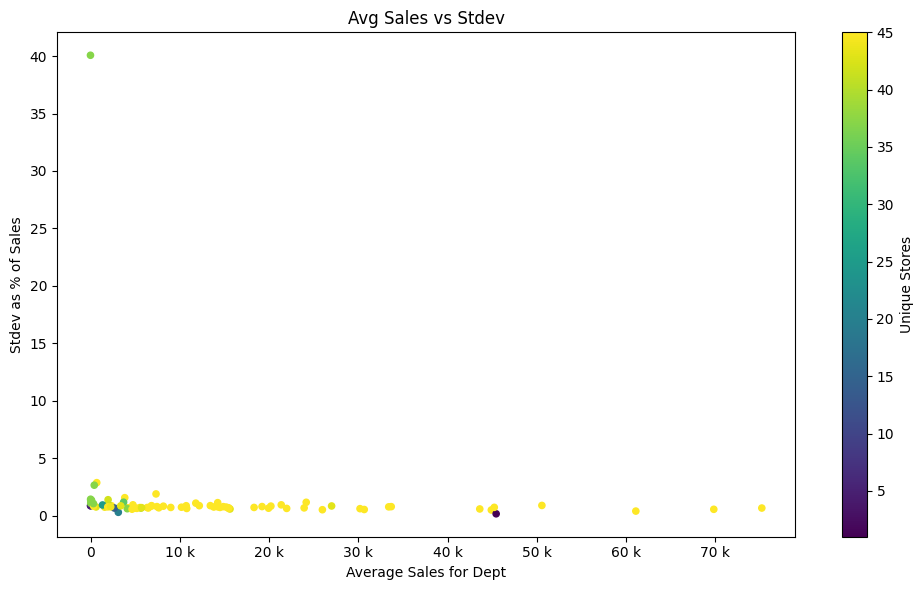

In [21]:
# Group and summarize data
Departments_summary = Sales_df.groupby('Dept').agg({
    "Weekly_Sales": ['sum', 'mean', 'min', 'max', 'std', 'var'],
    "Store": pd.Series.nunique
}).reset_index()

# Flatten the MultiIndex columns
Departments_summary.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in Departments_summary.columns]

# Rename columns for clarity
Departments_summary = Departments_summary.rename(columns={
    'Weekly_Sales_sum': 'Total Sales',
    'Weekly_Sales_mean': 'Average Sales',
    'Weekly_Sales_min': 'Minimum Sales',
    'Weekly_Sales_max': 'Maximum Sales',
    'Weekly_Sales_std': 'Sales Std Dev',
    'Weekly_Sales_var': 'Sales Variance',
    'Store_nunique': 'Unique Stores'
})

Departments_summary['PercStdev'] = np.sqrt(np.square(Departments_summary['Sales Std Dev'])/np.square(Departments_summary['Average Sales']))

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

scatter = Departments_summary.plot(
    kind='scatter',
    x='Average Sales',
    y='PercStdev',
    c='Unique Stores',
    colormap='viridis',
    ax=ax
)

# Add titles and labels
ax.set_title('Avg Sales vs Stdev')
ax.set_ylabel('Stdev as % of Sales')
ax.set_xlabel('Average Sales for Dept')

# Format axes
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# Show plot
plt.tight_layout()
plt.show()


In [33]:
    # create a datafile listing Departments, counting the number of stores per type, no of unique trading periods per type, average annual weekly sales by type, average winter,spring,summer,autumn sales by type, average holiday sales by type, average non holiday sales by type
    Departments2 = Sales_df.groupby(['Dept','Type']).agg({'Weekly_Sales': 'mean', "Store": pd.Series.nunique, "Date": pd.Series.nunique })
    Departments2 = Departments2.rename(columns={
            'Weekly_Sales_mean': 'Average Sales',
            'Store_nunique': 'Unique Stores',
            'Date_nunique': 'Unique Dates'
            })

In [37]:
Departments2.unpack(0)

AttributeError: 'DataFrame' object has no attribute 'unpack'

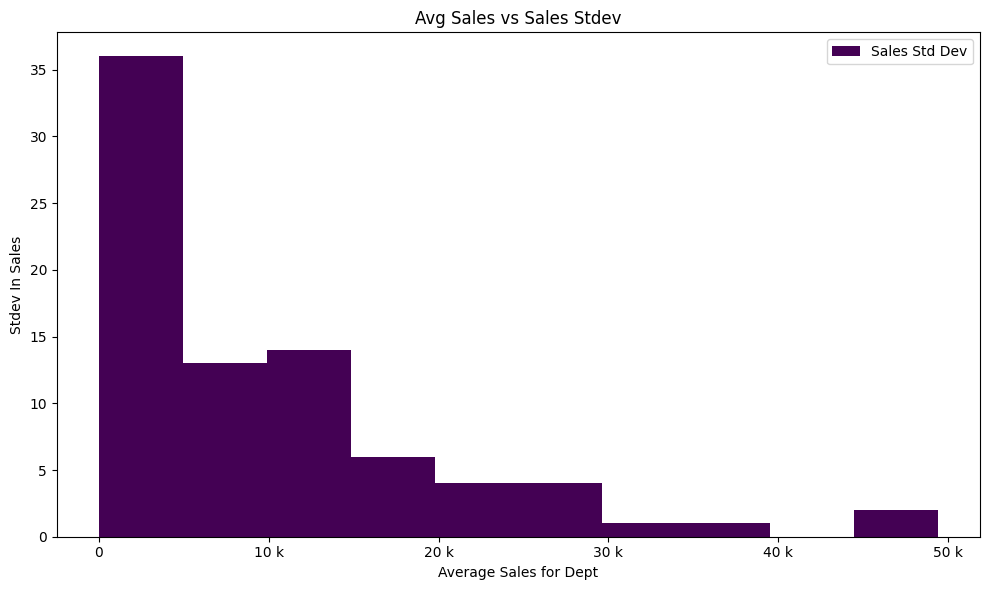

In [36]:
# Create the histogram plot
fig, ax = plt.subplots(figsize=(10, 6))

scatter = Departments_summary.plot(
    kind='hist',
    x='Average Sales',
    y='Sales Std Dev',
    # c='Unique Stores',
    colormap='viridis',
    ax=ax
)

# Add titles and labels
ax.set_title('Avg Sales vs Sales Stdev')
ax.set_ylabel('Stdev In Sales')
ax.set_xlabel('Average Sales for Dept')

# Format axes
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# Show plot
plt.tight_layout()
plt.show()



---